In [85]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [84]:
train = pd.read_csv('train_features_10k.csv')
test = pd.read_csv('test_features_10k.csv')
train_targets = pd.read_csv('train_targets_10k.csv')
submission = pd.read_csv('sample_submission.csv')

In [98]:
n_fold = 4
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [97]:
def train_model(X=train, X_test=test, y=train_targets, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=50)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=50, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [99]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Apr 28 15:10:07 2019
Training until validation scores don't improve for 50 rounds.


KeyboardInterrupt: 

In [ ]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=train, X_test=test, params=xgb_params, model_type='xgb')

In [90]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=train, X_test=test, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Apr 28 10:16:06 2019
Fold 0. MAE: 2.0873.

Fold 1 started at Sun Apr 28 11:03:31 2019
Fold 1. MAE: 2.0796.

Fold 2 started at Sun Apr 28 11:50:24 2019
Fold 2. MAE: 2.1276.

Fold 3 started at Sun Apr 28 12:37:47 2019
Fold 3. MAE: 2.1445.

Fold 4 started at Sun Apr 28 13:26:36 2019


KeyboardInterrupt: 

In [73]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=train, X_test=test, params=None, model_type='sklearn', model=model)

Fold 0 started at Fri Apr 26 15:00:02 2019
Fold 0. MAE: 2.4958.

Fold 1 started at Fri Apr 26 15:00:19 2019
Fold 1. MAE: 2.4247.

Fold 2 started at Fri Apr 26 15:00:35 2019
Fold 2. MAE: 2.4446.

Fold 3 started at Fri Apr 26 15:00:52 2019
Fold 3. MAE: 2.2434.

Fold 4 started at Fri Apr 26 15:01:08 2019
Fold 4. MAE: 2.3821.

CV mean score: 2.3981, std: 0.0856.


In [74]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=train, X_test=test, params=params, model_type='cat')

Fold 0 started at Fri Apr 26 15:01:25 2019


KeyboardInterrupt: 

In [75]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=train, X_test=test, params=None, model_type='sklearn', model=model)

Fold 0 started at Fri Apr 26 15:02:11 2019
Fold 0. MAE: 5.7941.

Fold 1 started at Fri Apr 26 15:02:14 2019
Fold 1. MAE: 5.6825.

Fold 2 started at Fri Apr 26 15:02:16 2019
Fold 2. MAE: 5.7132.

Fold 3 started at Fri Apr 26 15:02:18 2019
Fold 3. MAE: 5.5178.

Fold 4 started at Fri Apr 26 15:02:21 2019
Fold 4. MAE: 5.7059.

CV mean score: 5.6827, std: 0.0906.


In [96]:
#np.savetxt(prediction_xgb, 'xgb_prediction_10k.csv', delimiter=",")
#np.savetxt(prediction_lgb, 'lgb_prediction_10k.csv', delimiter=",")
prediction_nn = pd.read_csv('test_outputs_FFNN_10k.csv', header = None)
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + np.array(prediction_nn))/3 #+ prediction_cat + prediction_r) / 6

print(submission.head())
submission.to_csv('ensamble_submission.csv', index=False)

       seg_id    time_to_failure
0  seg_00030f  3.281799324716621
1  seg_0012b5  3.394536691383288
2  seg_00184e  4.344840258049955
3  seg_003339  5.138907924716621
4  seg_0042cc  3.690206924716621


In [95]:
prediction_nn

,0
0,0.000000000000000
1,3.558110200000000
2,3.896322300000000
3,6.747233000000000
4,9.129436000000000
5,4.783333000000000
6,4.136867000000000
7,7.010926000000000
8,3.916144000000000
9,3.506543200000000


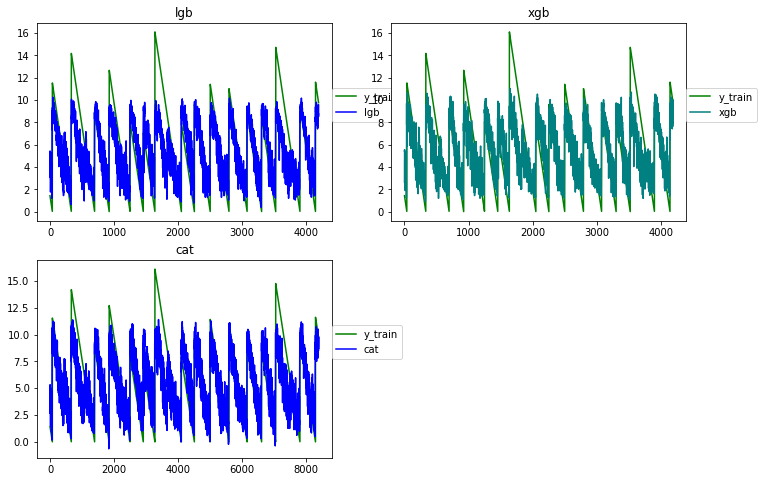

In [81]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.plot(train_targets, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 3, 2)
plt.plot(train_targets, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 3, 4)
plt.plot(train_targets_75, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');